# **Bank Customer Churn Prediction**
This notebook focuses on predicting customer churn using the Churn_Modelling dataset. We use feature engineering, EDA, and machine learning models (RandomForest and XGBoost) to achieve accurate predictions.


## 1. Import Libraries
We start by importing the necessary libraries for data manipulation, visualization, and modeling.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore the Dataset
We load the dataset and explore the columns and basic information about the data.

In [2]:
df = pd.read_csv(r"C:\ML Datasets\bank_customer_churn\archive (6)\Churn_Modelling.csv")
df.head()
df.columns
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 3. Data Preprocessing
We remove unnecessary columns like RowNumber, CustomerId, and Surname, as they don’t provide any useful information for the prediction.

In [3]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


## 4. Exploratory Data Analysis (EDA)
Churn Distribution
We explore the distribution of target variable Exited, which represents whether a customer churned or not.



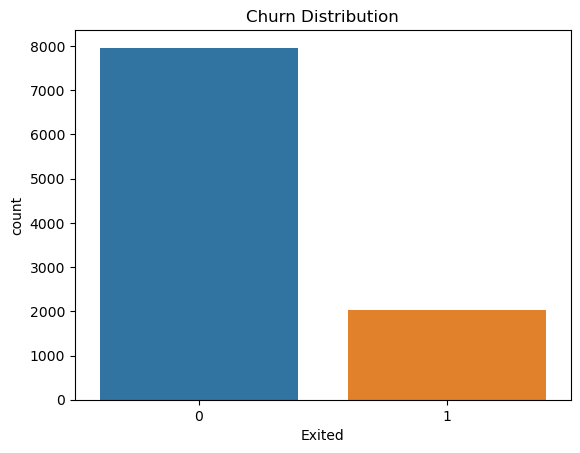

In [4]:
sns.countplot(data=df,x='Exited')
plt.title('Churn Distribution')
plt.show()


## Gender Distribution
We explore the gender distribution in the dataset.

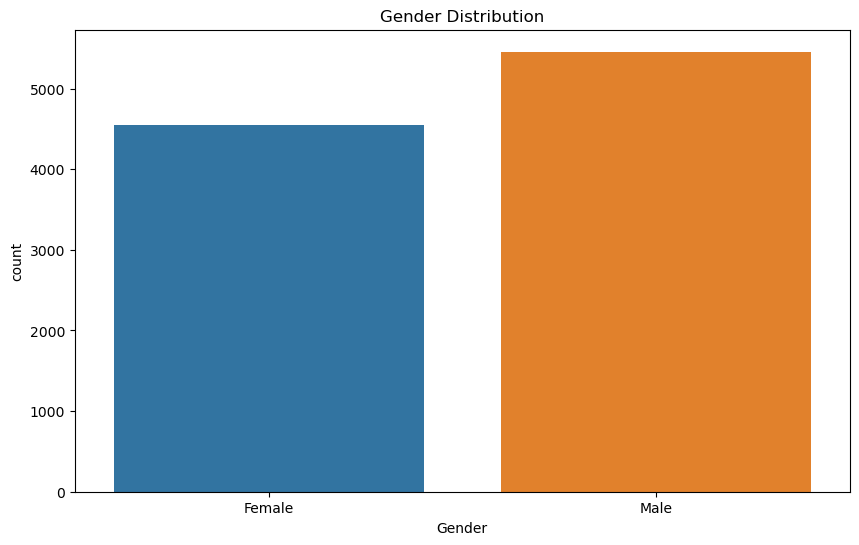

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Gender')
plt.title('Gender Distribution')
plt.show()


## Geography Distribution

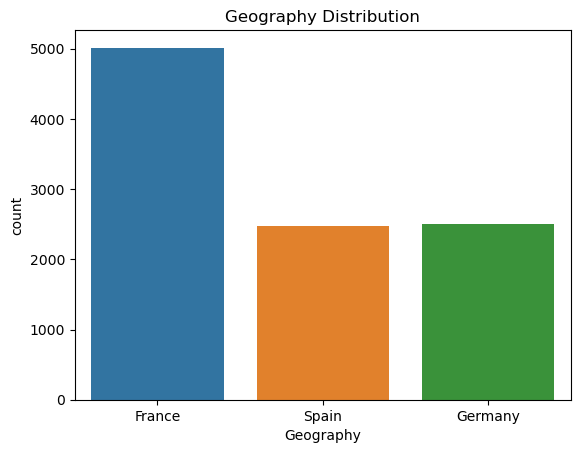

In [6]:
sns.countplot(data=df,x='Geography')
plt.title('Geography Distribution')
plt.show()


## Credit Card Holders

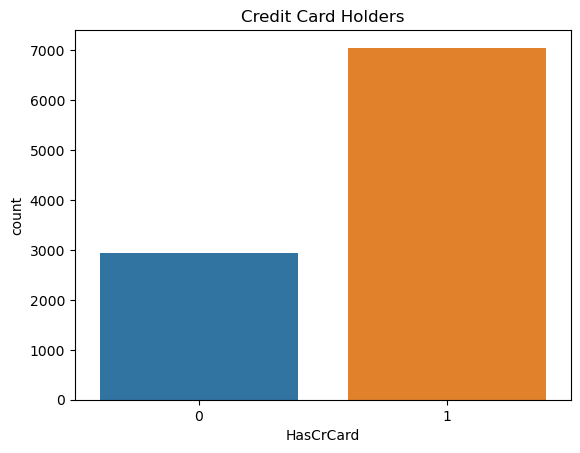

In [7]:
sns.countplot(data=df,x='HasCrCard')
plt.title('Credit Card Holders')
plt.show()


## Active Members Distribution

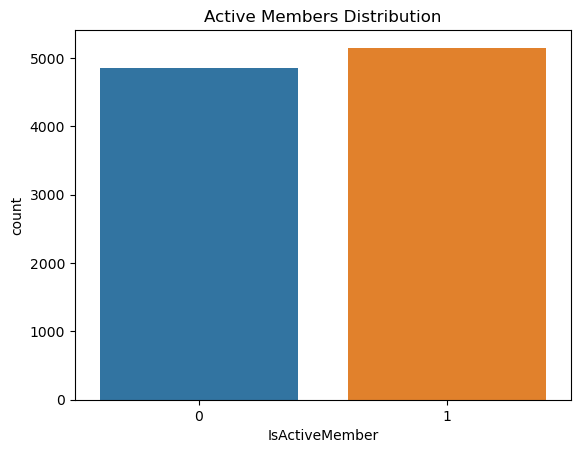

In [8]:
sns.countplot(data=df,x='IsActiveMember')
plt.title('Active Members Distribution')
plt.show()


## Churn by Gender
We explore how churn varies by gender.

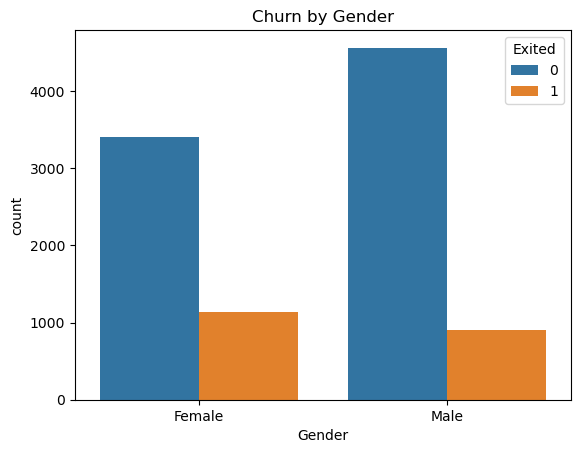

In [9]:
sns.countplot(data=df,x='Gender',hue='Exited')
plt.title('Churn by Gender')
plt.show()


## Churn by Geography

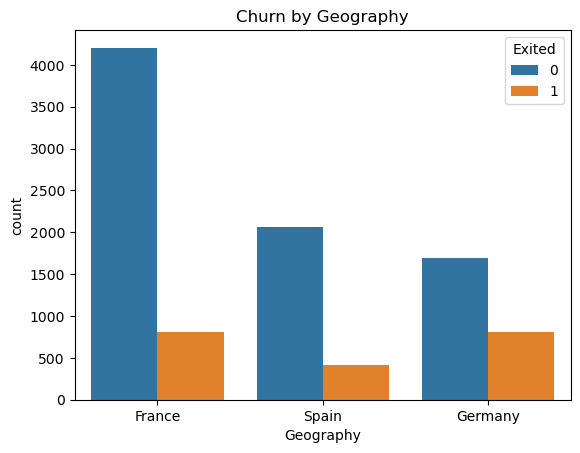

In [10]:
sns.countplot(data=df,x='Geography',hue='Exited')
plt.title('Churn by Geography')
plt.show()


## Churn by Tenure

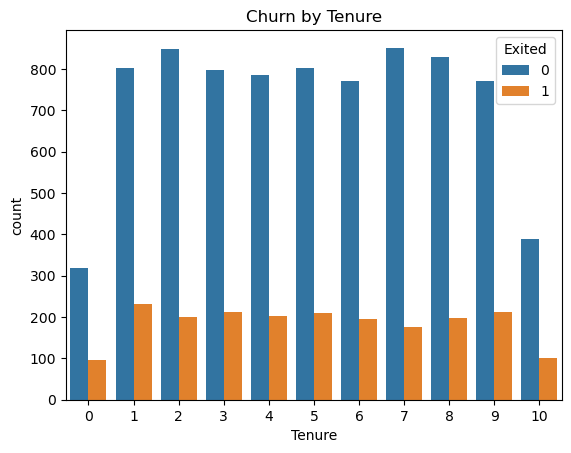

In [11]:
sns.countplot(x='Tenure',hue='Exited',data=df)
plt.title('Churn by Tenure')
plt.show()


## 5. Feature Engineering
We create new features to enhance our model's predictive power.

HasZeroBalance
We create a binary feature to check if the customer has zero balance.

In [12]:
df['HasZeroBalance'] = df['Balance'].apply(lambda x:1 if x == 0 else 0)


## Balance to Salary Ratio

In [13]:
df['BalanceToSalaryRatio'] = df['Balance'] / (df['EstimatedSalary'] + 1)


## Age Group
We categorize age into different groups.

In [14]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,30,50,100], labels=['Young','MiddleAged','Senior'])


## Risk Level Based on Credit Score
We create a risk level feature based on credit score

In [15]:
df['Risklevel'] = pd.cut(df['CreditScore'], bins=[350,500,700,900], labels=['HighRisk','MediumRisk','LowRisk'])


## SalaryTenure and LoyaltyScore

In [16]:
df['SalaryTenure'] = df['EstimatedSalary'] * df['Tenure']
df['LoyalityScore'] = df['NumOfProducts'] * df['Balance'] * df['Tenure']


## Visualizing New Features
Churn by Age Group

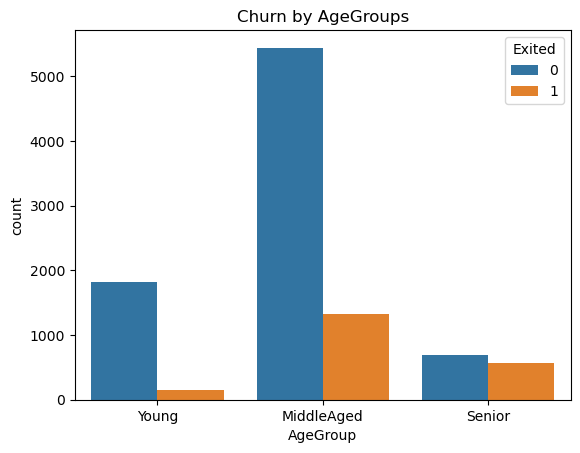

In [17]:
sns.countplot(data=df,x='AgeGroup',hue='Exited')
plt.title('Churn by AgeGroups')
plt.show()


## Churn by Risk Level

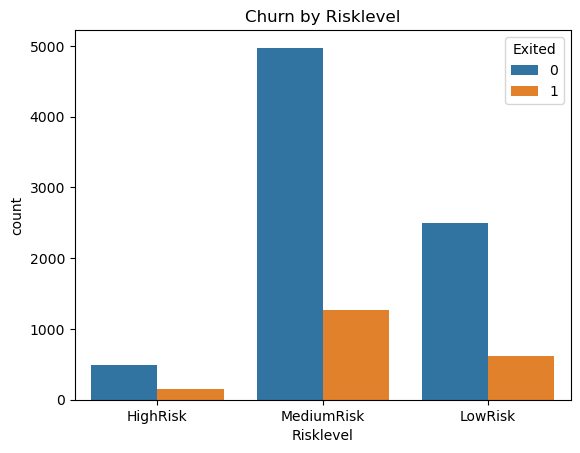

In [18]:
sns.countplot(data=df,x='Risklevel',hue='Exited')
plt.title('Churn by Risklevel')
plt.show()


## 6. Data Preprocessing for Modeling
Label Encoding and One-Hot Encoding
We encode the categorical columns for modeling.

In [19]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)


In [20]:
df.head()
df = df.drop(columns=['AgeGroup','Risklevel'],axis=1)

## Column Transformer for Scaling and Encoding
We prepare a column transformer to handle numerical scaling and one-hot encoding.

In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                      'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 
                      'HasZeroBalance', 'BalanceToSalaryRatio', 'SalaryTenure', 'LoyalityScore']

ct = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features)],
    remainder='passthrough')



## 7. Splitting the Data
We split the data into training and testing sets.

In [25]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Exited'])
y = df['Exited']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [27]:
X_test.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,HasZeroBalance,BalanceToSalaryRatio,SalaryTenure,LoyalityScore,Geography_Germany,Geography_Spain
6252,596,1,32,3,96709.07,2,0,0,41788.37,0,2.314203,125365.11,580254.42,1,0
4684,623,1,43,1,0.00,2,1,1,146379.30,1,0.000000,146379.30,0.00,0,0
1731,601,0,44,4,0.00,2,1,0,58561.31,1,0.000000,234245.24,0.00,0,1
4742,506,1,59,8,119152.10,2,1,1,170679.74,0,0.698099,1365437.92,1906433.60,1,0
4521,560,0,27,7,124995.98,1,1,1,114669.79,0,1.090042,802688.53,874971.86,0,1


In [28]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,HasZeroBalance,BalanceToSalaryRatio,SalaryTenure,LoyalityScore,Geography_Germany,Geography_Spain
9254,686,1,32,6,0.00,2,1,1,179093.26,1,0.000000,1074559.56,0.00,0,0
1561,632,1,42,4,119624.60,2,1,1,195978.86,0,0.610392,783915.44,956996.80,1,0
1670,559,1,24,3,114739.92,1,1,0,85891.02,0,1.335862,257673.06,344219.76,0,1
6087,561,0,27,9,135637.00,1,1,0,153080.40,0,0.886045,1377723.60,1220733.00,0,0
6669,517,1,56,9,142147.32,1,0,0,39488.04,0,3.599665,355392.36,1279325.88,0,0


In [29]:
print(X_train.columns)
print(X_test.columns)


Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'HasZeroBalance',
       'BalanceToSalaryRatio', 'SalaryTenure', 'LoyalityScore',
       'Geography_Germany', 'Geography_Spain'],
      dtype='object')
Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'HasZeroBalance',
       'BalanceToSalaryRatio', 'SalaryTenure', 'LoyalityScore',
       'Geography_Germany', 'Geography_Spain'],
      dtype='object')


In [30]:
X_train_processed = ct.fit_transform(X_train)
X_test_proccesed = ct.transform(X_test)

## 8. Random Forest Classifier
We train a Random Forest Classifier and evaluate its performance.

## Training the Model





In [31]:

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=6, criterion='gini', 
                             min_samples_split=2, min_samples_leaf=2, bootstrap=True)
rfc.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=6, max_features='auto', min_samples_leaf=2)

## Predictions and Evaluation

In [32]:
from sklearn.metrics import classification_report, r2_score, roc_auc_score

y_pred = rfc.predict(X_test_proccesed)
print(classification_report(y_test, y_pred))

print('roc score:', roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1607
           1       0.86      0.32      0.47       393

    accuracy                           0.86      2000
   macro avg       0.86      0.65      0.69      2000
weighted avg       0.86      0.86      0.83      2000

roc score: 0.6540825681536407


## 9. Hyperparameter Tuning with GridSearchCV
We perform hyperparameter tuning using GridSearchCV.

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': [4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 4, 5],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
grid.fit(X_train_processed, y_train)

print(grid.best_params_)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
{'bootstrap': True, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Evaluating the Best Model

In [34]:
model = grid.best_estimator_
y_pred2 = model.predict(X_test_proccesed)
print(classification_report(y_test, y_pred2))
print('roc score:', roc_auc_score(y_test, y_pred2))


              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1607
           1       0.83      0.39      0.53       393

    accuracy                           0.86      2000
   macro avg       0.85      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000

roc score: 0.6850111867450134


## 10. XGBoost Classifier
We train an XGBoost Classifier and evaluate its performance.

## Training the Model

In [35]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=5, min_child_weight=3)
xgb.fit(X_train_processed, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Predictions and Evaluation

In [36]:
y_pred3 = xgb.predict(X_test_proccesed)
print(classification_report(y_test, y_pred3))
print('roc score:', roc_auc_score(y_test, y_pred3))


              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1607
           1       0.89      0.30      0.44       393

    accuracy                           0.85      2000
   macro avg       0.87      0.64      0.68      2000
weighted avg       0.86      0.85      0.82      2000

roc score: 0.6432267544505511


## 11. Hyperparameter Tuning with GridSearchCV for XGBoost
We perform hyperparameter tuning for XGBoost.

In [37]:
param_grid2 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.001]
}

xgb_grid = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid2, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
xgb_grid.fit(X_train_processed, y_train)

print(xgb_grid.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


## Evaluating the Best Model


In [38]:
model4 = xgb_grid.best_estimator_
y_pred4 = model4.predict(X_test_proccesed)
print(classification_report(y_test, y_pred4))
print('roc score:', roc_auc_score(y_test, y_pred4))


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.47      0.58       393

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000

roc score: 0.7151172272706401


## 12. Feature Importance and Visualization
We visualize the feature importance using the XGBoost model.

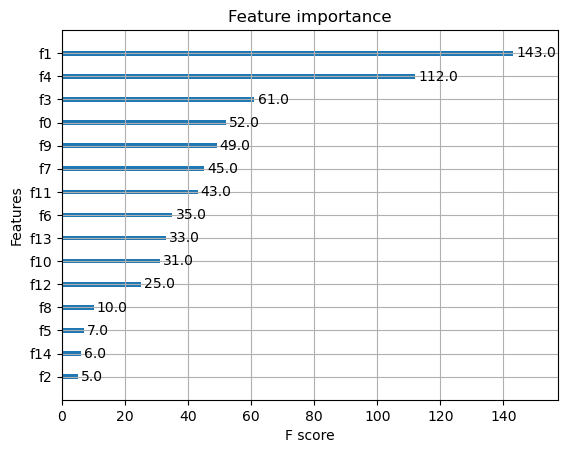

In [39]:
from xgboost import plot_importance

plot_importance(model4, importance_type='weight')
plt.show()





## 13. Confusion Matrix
We plot the confusion matrix for the final XGBoost model.

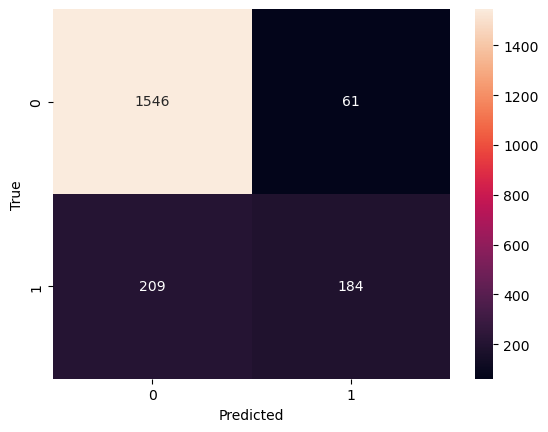

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred4)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Model Evaluation using Classification Report and ROC Curve

The following code evaluates the performance of a classification model using two common metrics:

1. **Classification Report**: A detailed report that provides precision, recall, F1-score, and support for each class. It helps understand how well the model is performing in terms of correctly predicting positive and negative samples.

2. **ROC Curve (Receiver Operating Characteristic)**: A graphical plot that illustrates the diagnostic ability of a binary classifier. It shows the trade-off between the True Positive Rate (Sensitivity) and the False Positive Rate (1 - Specificity) at various threshold settings. The Area Under the Curve (AUC) indicates the model's ability to distinguish between classes, with a score closer to 1.0 indicating better performance.

The ROC curve is plotted using the False Positive Rate (x-axis) and True Positive Rate (y-axis), with the AUC value displayed in the legend. A diagonal red line indicates a random classifier's performance for reference.


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.47      0.58       393

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000



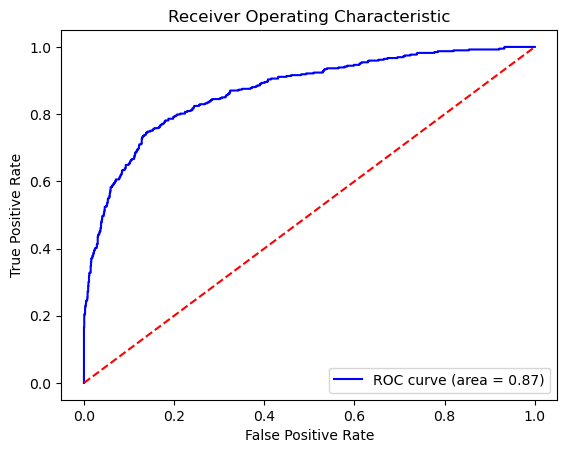

In [41]:
from sklearn.metrics import classification_report, roc_curve, auc

# Assuming you have your predictions and true labels
y_true = y_test
y_pred = model4.predict(X_test_proccesed)

# Classification report
print(classification_report(y_true, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, model4.predict_proba(X_test_proccesed)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
